# K-Means Clustering for Customer Personas

**Objective**: Apply K-means clustering to the behavioral features to identify distinct customer personas.

## Workflow
1. Load pre-processed features from notebook 02
2. Scale features with StandardScaler
3. Determine optimal k using elbow and silhouette analysis
4. Fit final model and assign cluster labels
5. Export results for Phase 2 (persona profiling)

## 1. Environment Setup

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Paths
DATA_DIR = Path('../data/processed')
OUTPUT_DIR = Path('../data/processed')
FIG_DIR = Path('./outputs/03_clustering')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Figure directory: {FIG_DIR.resolve()}")

Data directory: /Users/emilyhk/practice/blok-persona-clustering/data/processed
Figure directory: /Users/emilyhk/practice/blok-persona-clustering/notebooks/outputs/03_clustering


## 2. Load Pre-Processed Features

In [ ]:
# Load transformed features (already log-transformed where needed)
features_df = pd.read_csv(DATA_DIR / 'customer_features_transformed.csv', index_col='customer_unique_id')

print(f"Loaded feature matrix: {features_df.shape}")
print(f"  - Customers: {len(features_df):,}")
print(f"  - Features: {len(features_df.columns)}")
print(f"\nFeatures:")
for col in features_df.columns:
    print(f"  - {col}")

In [ ]:
# Quick summary
features_df.describe().T

## 3. Feature Scaling

K-means uses Euclidean distance, so features must be standardized (mean=0, std=1) to ensure equal contribution from each feature.

In [ ]:
# Fit StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"\nPost-scaling statistics (should be ~0 mean, ~1 std):")
print(f"  Mean: {X_scaled.mean(axis=0).round(6)}")
print(f"  Std:  {X_scaled.std(axis=0).round(4)}")

## 4. Determine Optimal k

Run K-means for k=2 to k=10 and evaluate using:
- **Inertia (WCSS)**: Within-cluster sum of squares — lower is better, but diminishing returns
- **Silhouette Score**: Cluster separation quality — ranges from -1 to 1, higher is better

In [17]:
# K selection analysis
K_RANGE = range(2, 11)

results = {
    'k': [],
    'inertia': [],
    'silhouette': []
}

print("Running K-means for k=2 to k=10...")
print("-" * 40)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_scaled, labels)
    
    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    
    print(f"k={k:2d} | Inertia: {inertia:12,.0f} | Silhouette: {silhouette:.4f}")

results_df = pd.DataFrame(results)
print("-" * 40)
print("Done.")

Running K-means for k=2 to k=10...
----------------------------------------


KeyboardInterrupt: 

## 5. Elbow and Silhouette Plots

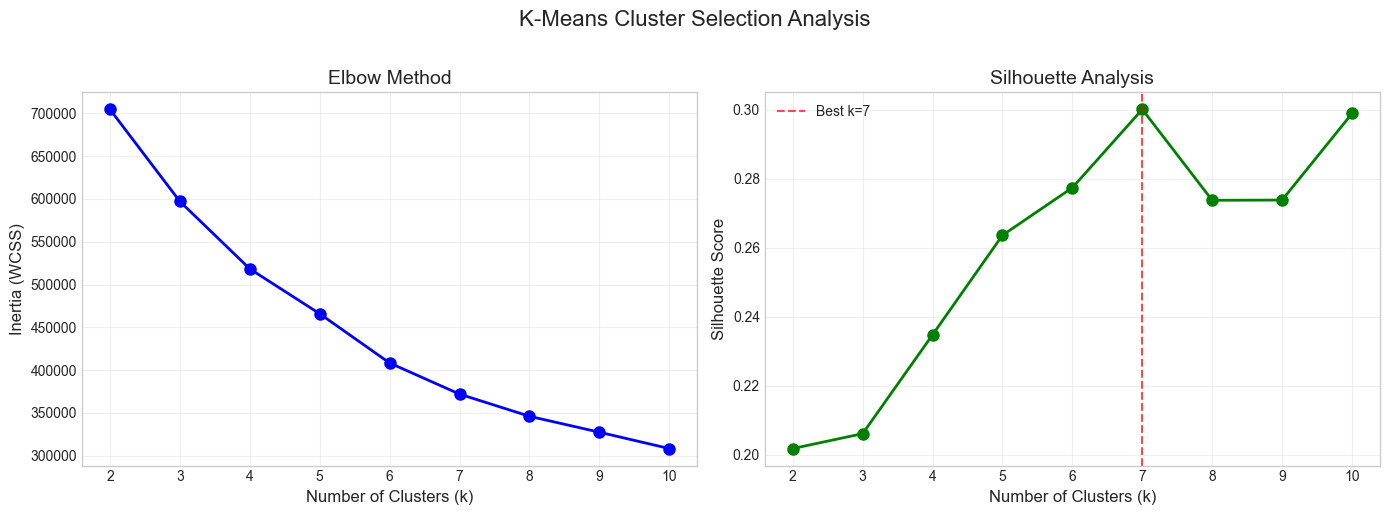


Best k by silhouette score: 7 (score: 0.3001)
Saved: outputs/03_clustering/elbow_silhouette_analysis.png


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot (Inertia)
axes[0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].set_xticks(list(K_RANGE))
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14)
axes[1].set_xticks(list(K_RANGE))
axes[1].grid(True, alpha=0.3)

# Highlight best silhouette
best_k_silhouette = results_df.loc[results_df['silhouette'].idxmax(), 'k']
best_silhouette = results_df['silhouette'].max()
axes[1].axvline(x=best_k_silhouette, color='r', linestyle='--', alpha=0.7, label=f'Best k={best_k_silhouette}')
axes[1].legend()

plt.suptitle('K-Means Cluster Selection Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'elbow_silhouette_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest k by silhouette score: {best_k_silhouette} (score: {best_silhouette:.4f})")
print(f"Saved: {FIG_DIR / 'elbow_silhouette_analysis.png'}")

In [ ]:
# Summary table
print("K Selection Summary:")
print("="*50)
results_df['inertia_change'] = results_df['inertia'].pct_change() * -100
results_df['inertia_change'] = results_df['inertia_change'].round(2)
print(results_df.to_string(index=False))

## 6. Fit Final Model

Based on the elbow and silhouette analysis above, select the optimal k and fit the final model.

In [21]:
# Select k based on analysis above
# NOTE: Adjust this value after reviewing the elbow/silhouette plots
OPTIMAL_K = 7  # Placeholder - update based on your analysis

print(f"Fitting final K-means model with k={OPTIMAL_K}...")

Fitting final K-means model with k=7...


In [22]:
# Fit final model
final_kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Add cluster labels to features dataframe
features_df['cluster'] = cluster_labels

print(f"Final model fitted.")
print(f"\nCluster distribution:")
cluster_counts = features_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(features_df) * 100
    print(f"  Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")

Final model fitted.

Cluster distribution:
  Cluster 0: 27,686 customers (29.7%)
  Cluster 1: 10,738 customers (11.5%)
  Cluster 2: 15,314 customers (16.4%)
  Cluster 3: 15,022 customers (16.1%)
  Cluster 4: 7,619 customers (8.2%)
  Cluster 5: 2,781 customers (3.0%)
  Cluster 6: 14,197 customers (15.2%)


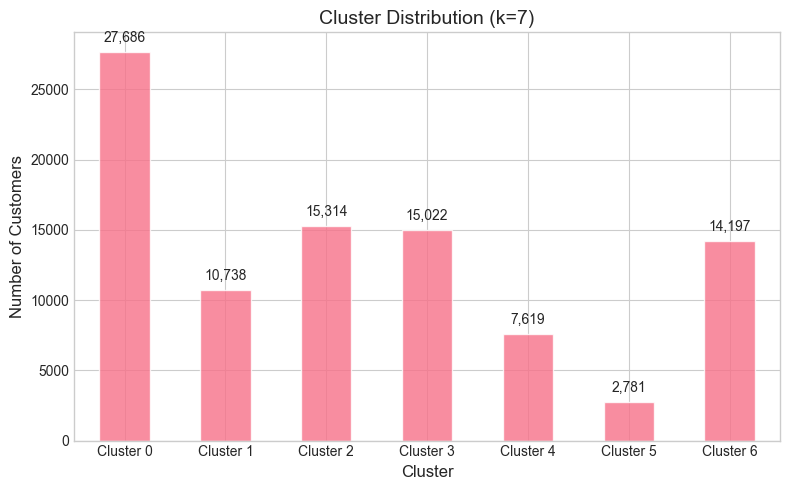

Saved: outputs/03_clustering/cluster_distribution.png


In [23]:
# Visualize cluster distribution
fig, ax = plt.subplots(figsize=(8, 5))
cluster_counts.plot(kind='bar', ax=ax, edgecolor='white', alpha=0.8)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
ax.set_title(f'Cluster Distribution (k={OPTIMAL_K})', fontsize=14)
ax.set_xticklabels([f'Cluster {i}' for i in range(OPTIMAL_K)], rotation=0)

# Add count labels on bars
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
    ax.text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / 'cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {FIG_DIR / 'cluster_distribution.png'}")

## 7. Cluster Quality Metrics

In [24]:
# Final model metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_inertia = final_kmeans.inertia_

print("Final Model Quality Metrics")
print("=" * 40)
print(f"Number of clusters (k): {OPTIMAL_K}")
print(f"Inertia (WCSS): {final_inertia:,.0f}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"\nInterpretation:")
print(f"  Silhouette > 0.5: Strong cluster structure")
print(f"  Silhouette 0.25-0.5: Reasonable structure")
print(f"  Silhouette < 0.25: Weak/overlapping clusters")

Final Model Quality Metrics
Number of clusters (k): 7
Inertia (WCSS): 372,020
Silhouette Score: 0.3001

Interpretation:
  Silhouette > 0.5: Strong cluster structure
  Silhouette 0.25-0.5: Reasonable structure
  Silhouette < 0.25: Weak/overlapping clusters


## 8. Cluster Profiles (Preview)

Quick look at cluster centroids to understand what differentiates each cluster.

In [25]:
# Cluster means (in original feature space, not scaled)
feature_cols = [col for col in features_df.columns if col != 'cluster']
cluster_profiles = features_df.groupby('cluster')[feature_cols].mean()

print("Cluster Profiles (Mean Feature Values):")
cluster_profiles.T

Cluster Profiles (Mean Feature Values):


cluster,0,1,2,3,4,5,6
frequency_log,0.6932,0.6932,0.6931,0.6932,0.6939,1.1283,0.6932
monetary_total_log,4.0740,4.2242,4.1987,5.5883,4.9716,5.2331,4.2226
monetary_avg_item_log,4.0732,4.2100,4.1715,5.5745,4.1306,4.3769,4.2211
avg_items_per_order_log,0.6937,0.7017,0.7094,0.7012,1.2160,0.7695,0.6940
avg_installments,2.1823,2.5725,1.0000,6.6909,3.4822,3.2863,2.1960
pct_credit_card,1.0000,1.0000,0.0000,0.9784,0.8115,0.7747,0.7352
category_diversity,0.9841,0.9831,0.9857,0.9907,1.0790,1.5969,0.9819
is_positive_reviewer,1.0000,1.0000,1.0000,0.8527,0.5772,0.7436,0.0000
is_weekend_shopper,0.0000,1.0000,0.1919,0.1544,0.1953,0.3538,0.2343


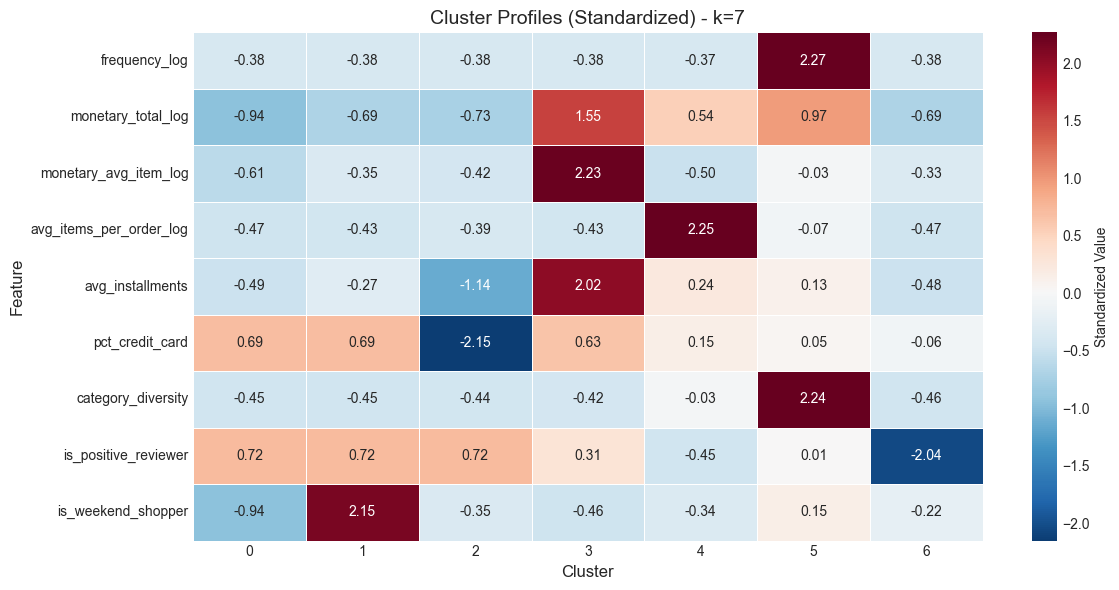

Saved: outputs/03_clustering/cluster_profiles_heatmap.png


In [26]:
# Heatmap of standardized cluster profiles
# Standardize by feature to show relative differences
cluster_profiles_std = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(cluster_profiles_std.T, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Standardized Value'})
ax.set_title(f'Cluster Profiles (Standardized) - k={OPTIMAL_K}', fontsize=14)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cluster_profiles_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {FIG_DIR / 'cluster_profiles_heatmap.png'}")

## 9. Export Results

In [27]:
# 1. Save cluster assignments
cluster_assignments = features_df[['cluster']].copy()
cluster_assignments.to_csv(OUTPUT_DIR / 'customer_clusters.csv')
print(f"Saved: {OUTPUT_DIR / 'customer_clusters.csv'}")

# 2. Save fitted scaler
with open(OUTPUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved: {OUTPUT_DIR / 'scaler.pkl'}")

# 3. Save fitted KMeans model
with open(OUTPUT_DIR / 'kmeans_model.pkl', 'wb') as f:
    pickle.dump(final_kmeans, f)
print(f"Saved: {OUTPUT_DIR / 'kmeans_model.pkl'}")

Saved: ../data/processed/customer_clusters.csv
Saved: ../data/processed/scaler.pkl
Saved: ../data/processed/kmeans_model.pkl


In [28]:
# 4. Update feature_metadata.json with clustering info
with open(OUTPUT_DIR / 'feature_metadata.json', 'r') as f:
    metadata = json.load(f)

metadata['clustering'] = {
    'algorithm': 'KMeans',
    'n_clusters': OPTIMAL_K,
    'random_state': 42,
    'n_init': 10,
    'scaler': 'StandardScaler',
    'inertia': float(final_inertia),
    'silhouette_score': float(final_silhouette),
    'cluster_sizes': cluster_counts.to_dict()
}

with open(OUTPUT_DIR / 'feature_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Updated: {OUTPUT_DIR / 'feature_metadata.json'}")

Updated: ../data/processed/feature_metadata.json


## 10. Summary

In [29]:
print("\n" + "="*60)
print("CLUSTERING COMPLETE")
print("="*60)

print(f"\nModel Configuration:")
print(f"  - Algorithm: K-Means")
print(f"  - Number of clusters: {OPTIMAL_K}")
print(f"  - Silhouette score: {final_silhouette:.4f}")

print(f"\nCluster Distribution:")
for cluster_id, count in cluster_counts.items():
    pct = count / len(features_df) * 100
    print(f"  Cluster {cluster_id}: {count:,} ({pct:.1f}%)")

print(f"\nOutput Files:")
print(f"  1. customer_clusters.csv - cluster assignments")
print(f"  2. scaler.pkl - fitted StandardScaler")
print(f"  3. kmeans_model.pkl - fitted KMeans model")
print(f"  4. feature_metadata.json - updated with clustering info")

print(f"\nNext Steps (Phase 2):")
print(f"  1. Profile each cluster with descriptive statistics")
print(f"  2. Generate natural language persona descriptions")
print(f"  3. Build Claude-powered persona agents")


CLUSTERING COMPLETE

Model Configuration:
  - Algorithm: K-Means
  - Number of clusters: 7
  - Silhouette score: 0.3001

Cluster Distribution:
  Cluster 0: 27,686 (29.7%)
  Cluster 1: 10,738 (11.5%)
  Cluster 2: 15,314 (16.4%)
  Cluster 3: 15,022 (16.1%)
  Cluster 4: 7,619 (8.2%)
  Cluster 5: 2,781 (3.0%)
  Cluster 6: 14,197 (15.2%)

Output Files:
  1. customer_clusters.csv - cluster assignments
  2. scaler.pkl - fitted StandardScaler
  3. kmeans_model.pkl - fitted KMeans model
  4. feature_metadata.json - updated with clustering info

Next Steps (Phase 2):
  1. Profile each cluster with descriptive statistics
  2. Generate natural language persona descriptions
  3. Build Claude-powered persona agents
